In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Updated paths
meta_dir = "../data/processed/metadata_cleaned"
model_save_path = "../saved_models/xgboost"
predictions_save_path = "../results/xgboost"

# Ensure output directories exist
os.makedirs(model_save_path, exist_ok=True)
os.makedirs(predictions_save_path, exist_ok=True)

# Updated cleaned metadata files
clients = {
    "Client 1": "client_1_meta_cleaned.csv",
    "Client 2": "client_2_meta_cleaned.csv",
    "Client 3": "client_3_meta_cleaned.csv",
    "Client 4": "client_4_meta_cleaned.csv"
}



📦 Training Client 1...
🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.9653    0.9460    0.9556       500
           1     0.9471    0.9660    0.9564       500

    accuracy                         0.9560      1000
   macro avg     0.9562    0.9560    0.9560      1000
weighted avg     0.9562    0.9560    0.9560      1000



/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:21:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


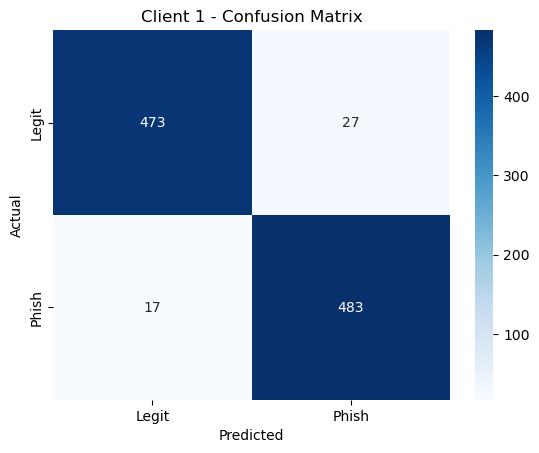

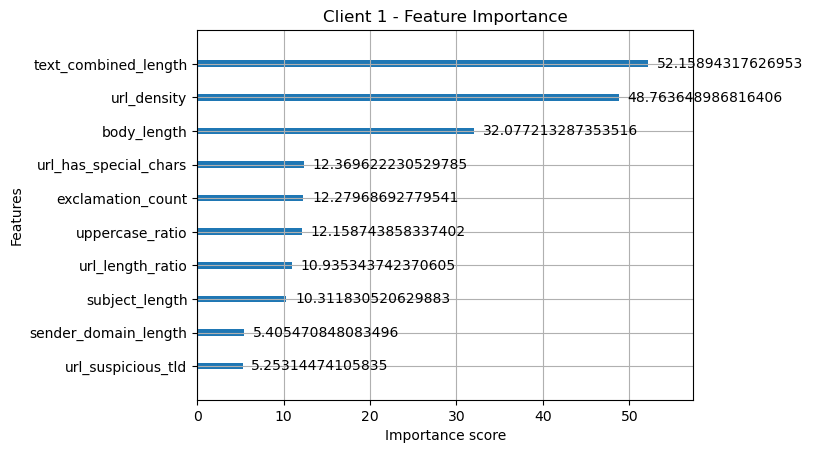

✅ Predictions saved: ../results/xgboost/client_1_xgb_predictions.csv

📦 Training Client 2...
🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.9154    0.9681    0.9410       313
           1     0.9661    0.9105    0.9375       313

    accuracy                         0.9393       626
   macro avg     0.9408    0.9393    0.9392       626
weighted avg     0.9408    0.9393    0.9392       626



/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


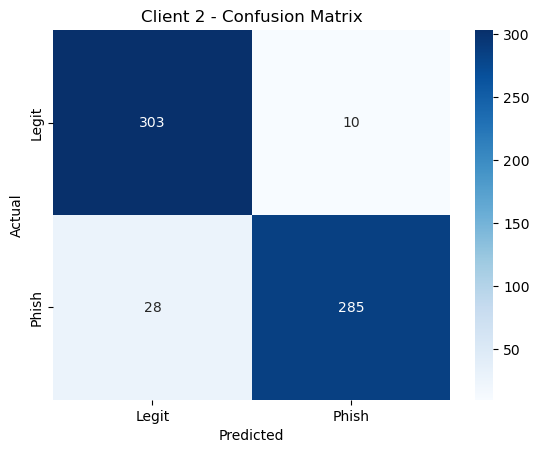

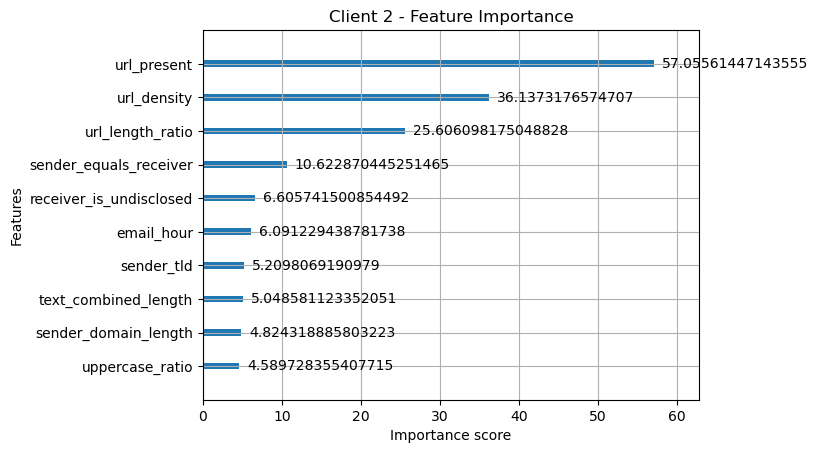

✅ Predictions saved: ../results/xgboost/client_2_xgb_predictions.csv

📦 Training Client 3...
🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.9352    0.9520    0.9435       667
           1     0.9449    0.9258    0.9353       593

    accuracy                         0.9397      1260
   macro avg     0.9401    0.9389    0.9394      1260
weighted avg     0.9398    0.9397    0.9396      1260



/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


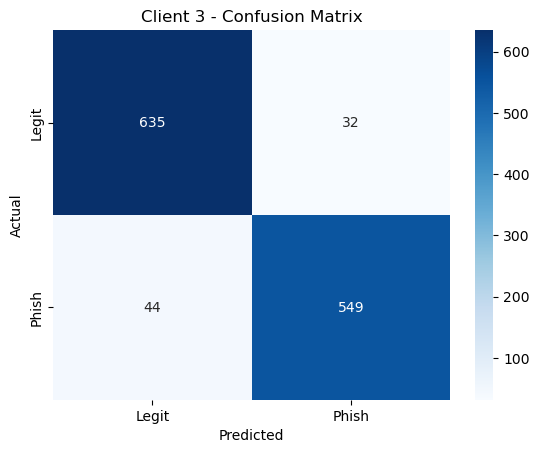

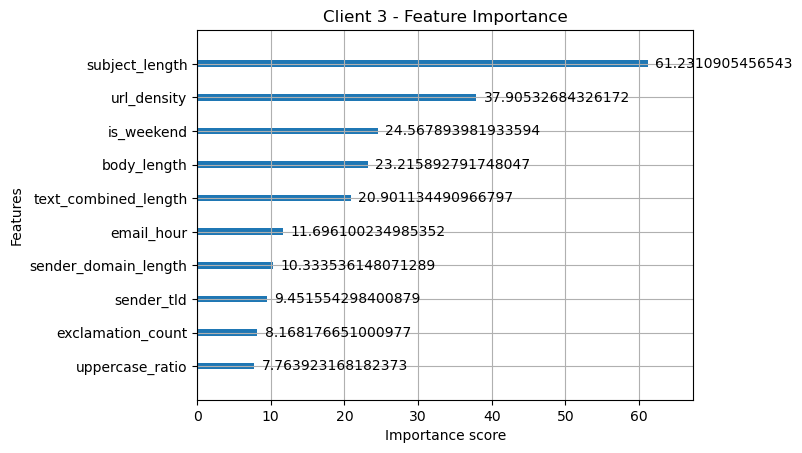

✅ Predictions saved: ../results/xgboost/client_3_xgb_predictions.csv

📦 Training Client 4...
🔍 Classification Report:
              precision    recall  f1-score   support

           0     0.9362    0.9390    0.9376       344
           1     0.9388    0.9360    0.9374       344

    accuracy                         0.9375       688
   macro avg     0.9375    0.9375    0.9375       688
weighted avg     0.9375    0.9375    0.9375       688



/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:21:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


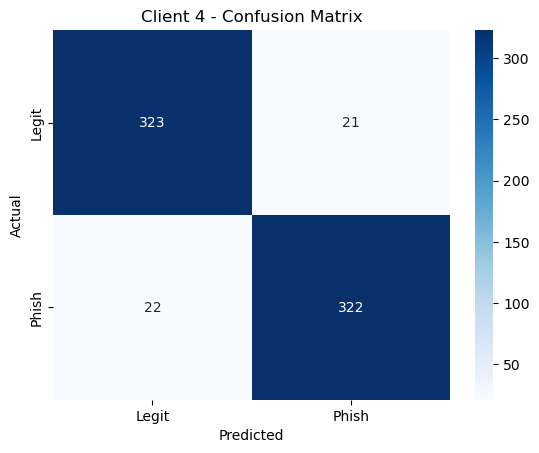

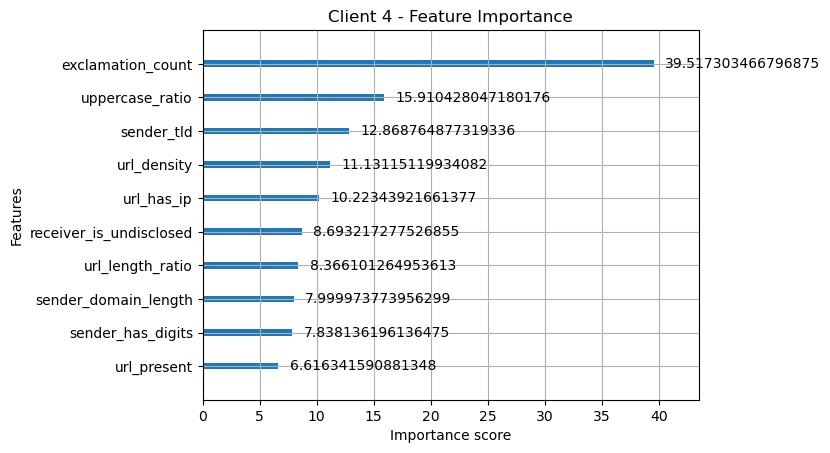

✅ Predictions saved: ../results/xgboost/client_4_xgb_predictions.csv


In [2]:
def plot_conf_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, annot=True, fmt='d', cmap="Blues",
        xticklabels=["Legit", "Phish"], yticklabels=["Legit", "Phish"]
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

for name, file in clients.items():
    print(f"\n📦 Training {name}...")

    # Load data
    df = pd.read_csv(os.path.join(meta_dir, file))
    X = df.drop(columns=["label"])
    y = df["label"]

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # Train XGBoost
    model = xgb.XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)

    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print("🔍 Classification Report:")
    print(classification_report(y_test, y_pred, digits=4))
    plot_conf_matrix(y_test, y_pred, title=f"{name} - Confusion Matrix")

    # Feature importance
    xgb.plot_importance(model, max_num_features=10, importance_type='gain', title=f"{name} - Feature Importance")
    plt.show()

    # Save predictions
    short_name = file.replace("_meta_cleaned.csv", "")
    pred_df = pd.DataFrame({
        "Actual": y_test,
        "Predicted": y_pred,
        "Probability": y_proba
    })
    pred_path = os.path.join(predictions_save_path, f"{short_name}_xgb_predictions.csv")
    pred_df.to_csv(pred_path, index=False)
    print(f"✅ Predictions saved: {pred_path}")


In [3]:
for name, file in clients.items():
    print(f"\n📦 Retraining {name} on full data...")

    df = pd.read_csv(os.path.join(meta_dir, file))
    X = df.drop(columns=["label"])
    y = df["label"]

    model = xgb.XGBClassifier(
        objective="binary:logistic",
        use_label_encoder=False,
        eval_metric="logloss",
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X, y)

    short_name = file.replace("_meta_cleaned.csv", "")
    model_path = os.path.join(model_save_path, f"{short_name}_xgb.json")
    model.save_model(model_path)
    print(f"✅ Model saved: {model_path}")



📦 Retraining Client 1 on full data...
✅ Model saved: ../saved_models/xgboost/client_1_xgb.json

📦 Retraining Client 2 on full data...
✅ Model saved: ../saved_models/xgboost/client_2_xgb.json

📦 Retraining Client 3 on full data...
✅ Model saved: ../saved_models/xgboost/client_3_xgb.json

📦 Retraining Client 4 on full data...


/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/envs/mbft_lite_env/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [10:22:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Paramet

✅ Model saved: ../saved_models/xgboost/client_4_xgb.json


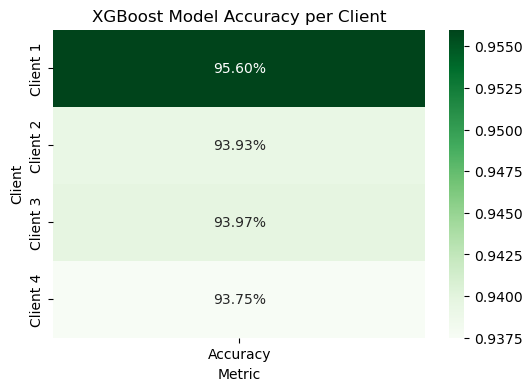

In [4]:
accuracy_results = {}

for name, file in clients.items():
    short_name = file.replace("_meta_cleaned.csv", "")
    pred_file = os.path.join(predictions_save_path, f"{short_name}_xgb_predictions.csv")
    pred_df = pd.read_csv(pred_file)

    accuracy = (pred_df["Actual"] == pred_df["Predicted"]).mean()
    accuracy_results[name] = accuracy

accuracy_df = pd.DataFrame.from_dict(accuracy_results, orient='index', columns=['Accuracy'])

plt.figure(figsize=(6, 4))
sns.heatmap(accuracy_df, annot=True, cmap='Greens', cbar=True, fmt=".2%")
plt.title("XGBoost Model Accuracy per Client")
plt.xlabel("Metric")
plt.ylabel("Client")
plt.show()


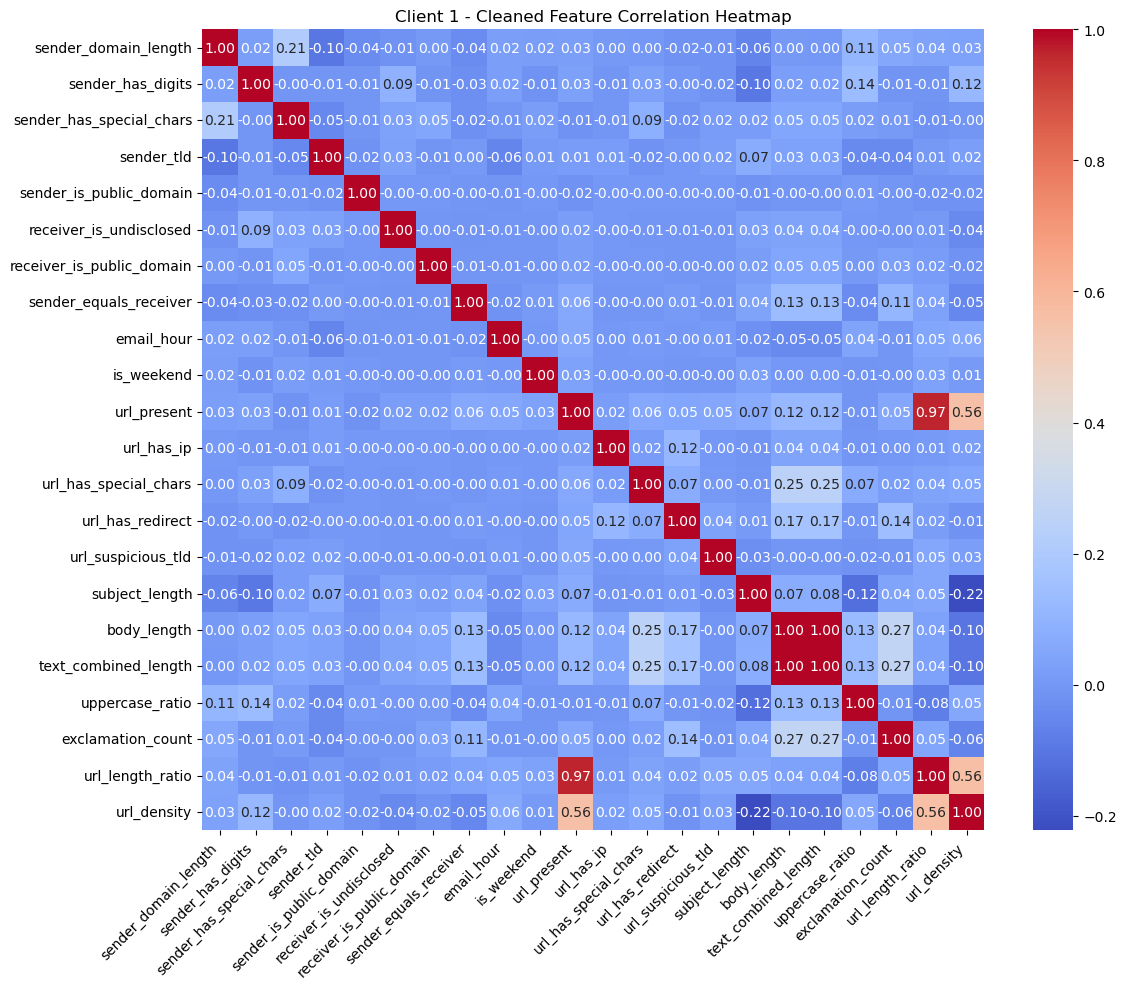

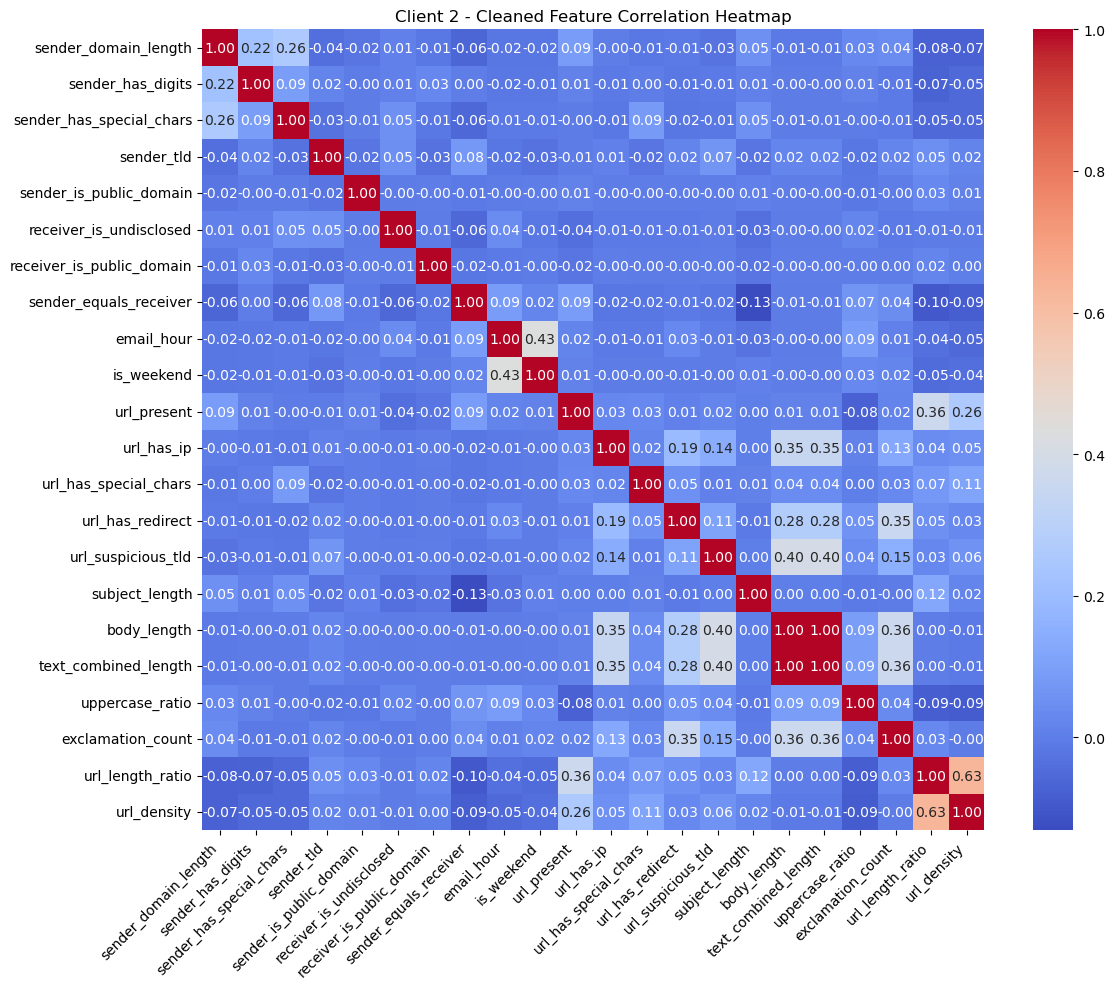

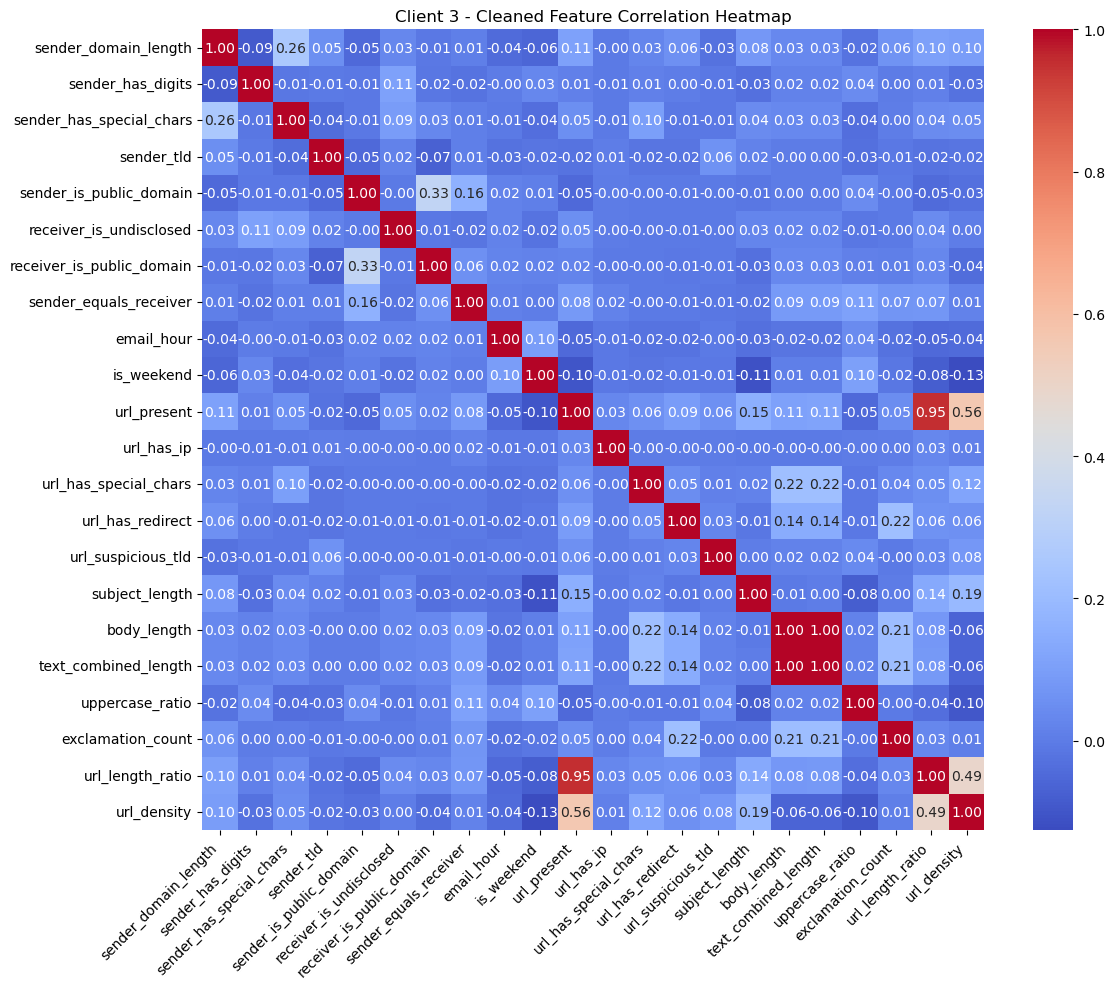

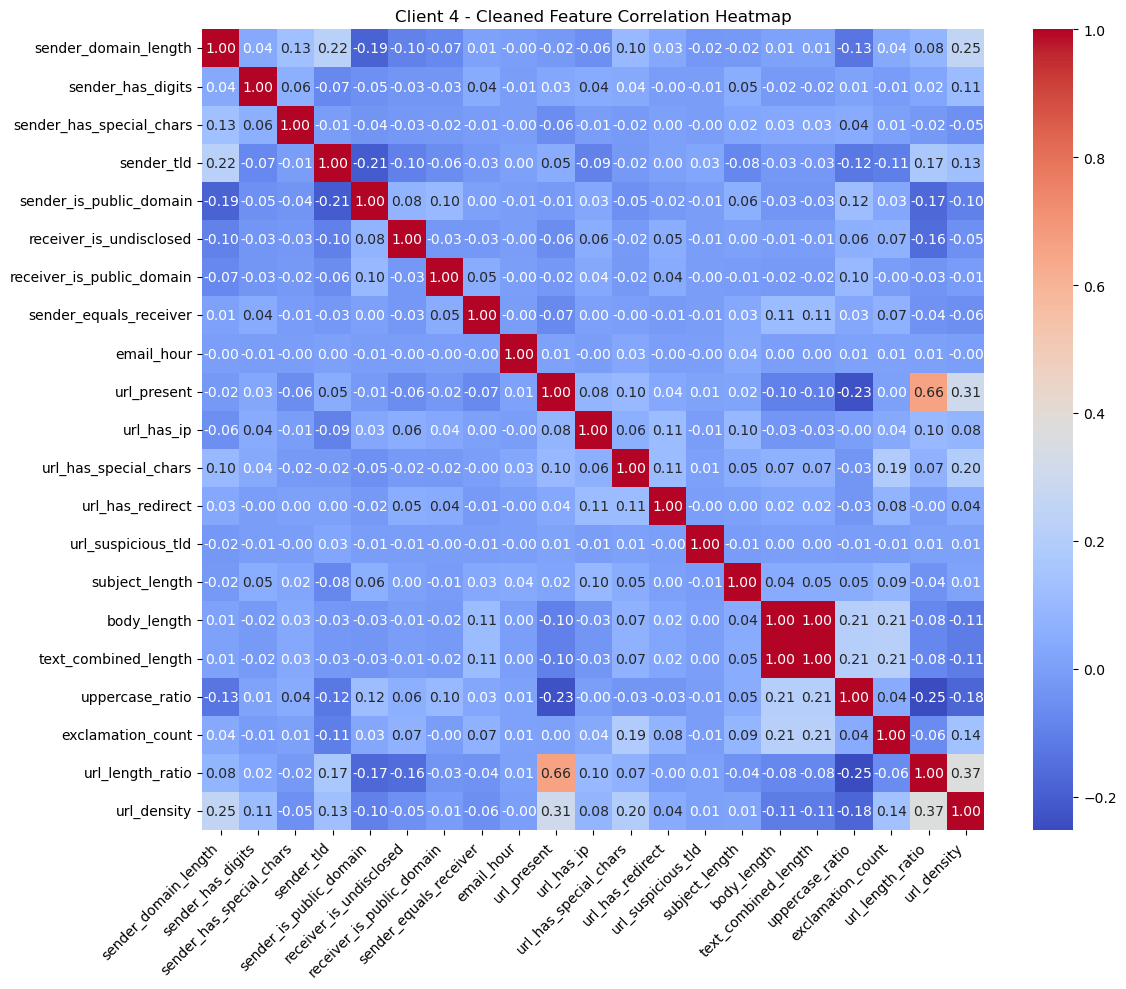

In [5]:
for name, file in clients.items():
    df = pd.read_csv(os.path.join(meta_dir, file))
    features_df = df.drop(columns=["label"])

    plt.figure(figsize=(12, 10))
    sns.heatmap(features_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
    plt.title(f"{name} - Cleaned Feature Correlation Heatmap")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
